# Demo 3: Grid

One important feature of KANs is that they embed splines to neural networks. However, splines are only valid for approximating functions in known bounded regions, while the range of activations in neural networks may be changing over training. So we have to update grids properly according to that. Let's first take a look at how we parametrize splines. 

In [49]:
from kan.spline import B_batch
import torch
import matplotlib.pyplot as plt
import numpy as np

# consider a 1D example.
# Suppose we have grid in [-1,1] with G intervals, spline order k
G = 5
k = 3
grid = torch.linspace(-1,1,steps=G+1)[None,:]
print("grid")
print(grid.size())
print(grid)
print("")

# and we have sample range in [-1,1]
x = torch.linspace(-1,1,steps=1001)[None,:]
print("x:")
print(x.size())
print(x)
print("")

basis = B_batch(x, grid, k=k)
print("basis:")
print(basis.size())
print(basis)

grid
torch.Size([1, 6])
tensor([[-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000]])

x:
torch.Size([1, 1001])
tensor([[-1.0000, -0.9980, -0.9960,  ...,  0.9960,  0.9980,  1.0000]])

basis:
torch.Size([1, 8, 1001])
tensor([[[0.1667, 0.1642, 0.1617,  ..., 0.0000, 0.0000, 0.0000],
         [0.6667, 0.6666, 0.6666,  ..., 0.0000, 0.0000, 0.0000],
         [0.1667, 0.1692, 0.1717,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1717, 0.1692, 0.1667],
         [0.0000, 0.0000, 0.0000,  ..., 0.6666, 0.6666, 0.6667],
         [0.0000, 0.0000, 0.0000,  ..., 0.1617, 0.1642, 0.1667]]])


Text(0, 0.5, 'B_i(x)')

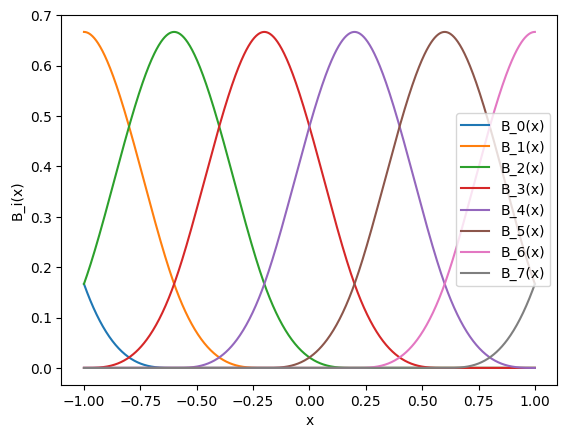

In [50]:

for i in range(G+k):
    plt.plot(x[0].detach().numpy(), basis[0,i,:].detach().numpy())
    
plt.legend(['B_{}(x)'.format(i) for i in np.arange(G+k)])
plt.xlabel('x')
plt.ylabel('B_i(x)')

There are $G+k$ B-spline basis. The function is a linear combination of these bases $${\rm spline}(x)=\sum_{i=0}^{G+k-1} c_i B_i(x).$$ We don't need worry about the implementation since it's already built in KAN. But let's check if KAN is indeed implementing this. We initialize a [1,1] KAN, which is simply a 1D spline.

In [55]:
from kan import KAN

model = KAN(width=[1,1], grid=G, k=k)
print(model)
# obtain coefficients c_i
print(model.act_fun[0].coef)
assert(model.act_fun[0].coef[0].shape[0] == G+k)

KAN(
  (biases): ModuleList(
    (0): Linear(in_features=1, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)
Parameter containing:
tensor([[-0.0023, -0.0042,  0.0143, -0.0023,  0.0124, -0.0124, -0.0016,  0.0007]],
       requires_grad=True)


tensor([[-1.0000, -0.9980, -0.9960,  ...,  0.9960,  0.9980,  1.0000]])

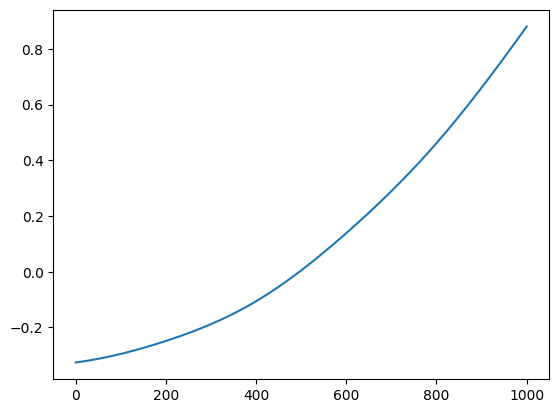

In [59]:
# the model forward
model_output = model(x[0][:,None])
plt.plot(model_output.detach().numpy())

tensor(0.1382, grad_fn=<MeanBackward0>)

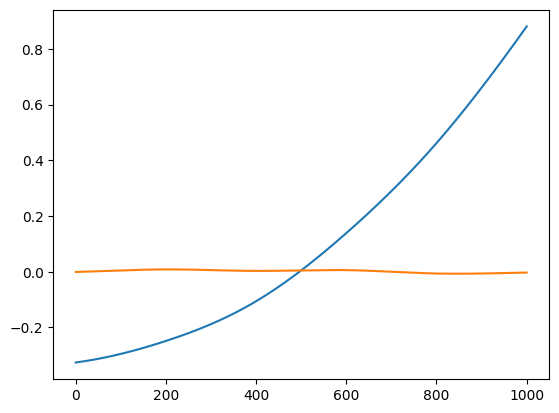

In [60]:
# spline output
spline_output = torch.einsum('i,ij->j',model.act_fun[0].coef[0], basis[0])[:,None]
plt.plot(model_output.detach().numpy())
plt.plot(spline_output.detach().numpy())
torch.mean((model_output - spline_output)**2)

They are not the same, what's happening? We want to remind that we model the activation function to have two additive parts, a residual function $b$(x) plus the spline function, i.e., $$\phi(x)={\rm scale\_base}*b(x)+{\rm scale\_sp}*{\rm spline}(x),$$ and by default $b(x)={\rm silu}(x)=x/(1+e^{-x})$.

tensor(0., grad_fn=<MeanBackward0>)

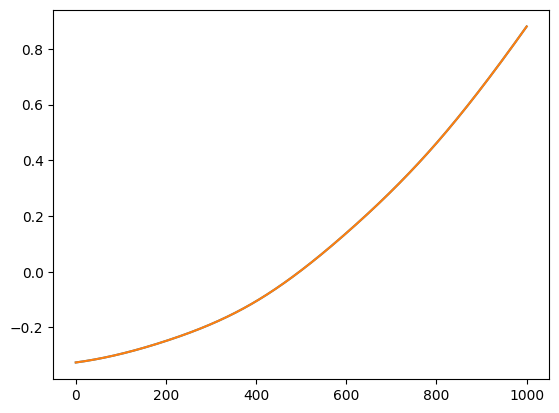

In [62]:
# residual output
residual_output = torch.nn.SiLU()(x[0][:,None])
scale_base = model.act_fun[0].scale_base
scale_sp = model.act_fun[0].scale_sp
plt.plot(model_output.detach().numpy())
plt.plot((scale_base * residual_output + scale_sp * spline_output).detach().numpy())
torch.mean((model_output - (scale_base * residual_output + scale_sp * spline_output))**2)

What if my grid does not match my data? For example, my grid is in [-1,1], but my data is in [10,10] or [-0.5,0.5]. Use update_grid_from_sample to adjust grids to samples. This grid update applies to all splines in all layers.

In [63]:
model = KAN(width=[1,1], grid=G, k=k)
print(model.act_fun[0].grid) # by default, the grid is in [-1,1]
x = torch.linspace(-10,10,steps = 1001)[:,None]
model.update_grid_from_samples(x)
print(model.act_fun[0].grid) # now the grid becomes in [-10,10]. We add a 0.01 margin in case x have zero variance

Parameter containing:
tensor([[-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000]])
Parameter containing:
tensor([[-10.0100,  -6.0060,  -2.0020,   2.0020,   6.0060,  10.0100]])


In [64]:
model = KAN(width=[1,1], grid=G, k=k)
print(model.act_fun[0].grid) # by default, the grid is in [-1,1]
x = torch.linspace(-0.5,0.5,steps = 1001)[:,None]
model.update_grid_from_samples(x)
print(model.act_fun[0].grid) # now the grid becomes in [-10,10]. We add a 0.01 margin in case x have zero variance

Parameter containing:
tensor([[-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000]])
Parameter containing:
tensor([[-0.5100, -0.3060, -0.1020,  0.1020,  0.3060,  0.5100]])


Uniform grid or non-uniform? We consider two options: (1) uniform grid; (2) adaptive grid (based on sample distribution) such that there are (rougly) same number of samples in each interval. We provide a parameter grid_eps to interpolate between these two regimes. grid_eps = 1 gives (1), and grid_eps = 0 gives (0). By default we set grid_eps = 1 (uniform grid). There could be other options but it is out of our scope here.

In [65]:
# uniform grid
model = KAN(width=[1,1], grid=G, k=k)
print(model.act_fun[0].grid) # by default, the grid is in [-1,1]
x = torch.normal(0,1,size=(1000,1))
model.update_grid_from_samples(x)
print(model.act_fun[0].grid) # now the grid becomes in [-10,10]. We add a 0.01 margin in case x have zero variance

Parameter containing:
tensor([[-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000]])
tensor([[ 2.2788e-01],
        [-5.5882e-01],
        [ 1.3559e-01],
        [ 2.3091e-01],
        [-6.1957e-01],
        [ 8.8478e-01],
        [-1.0662e+00],
        [ 1.5352e-01],
        [ 7.9252e-01],
        [-9.4544e-01],
        [-6.0887e-01],
        [ 9.0803e-01],
        [-1.2495e+00],
        [ 7.2948e-01],
        [-1.6031e-01],
        [ 1.0112e+00],
        [ 7.3353e-01],
        [-1.3219e+00],
        [ 1.3148e+00],
        [-1.4875e+00],
        [-7.1358e-01],
        [ 5.2000e-01],
        [-9.5289e-01],
        [-9.1742e-02],
        [ 1.0469e+00],
        [ 1.5430e-01],
        [-7.4989e-01],
        [-7.2339e-01],
        [ 8.6370e-02],
        [-1.7464e+00],
        [ 1.0410e+00],
        [ 6.5392e-01],
        [ 2.1166e-01],
        [ 1.3557e-01],
        [-3.3893e-02],
        [ 4.6047e-01],
        [ 1.1174e+00],
        [ 3.6904e-01],
        [-1.8720e-01],
        [-3.1453

In [7]:
# adaptive grid based on sample distribution
model = KAN(width=[1,1], grid=G, k=k, grid_eps = 0.)
print(model.act_fun[0].grid) # by default, the grid is in [-1,1]
x = torch.normal(0,1,size=(1000,1))
model.update_grid_from_samples(x)
print(model.act_fun[0].grid) # now the grid becomes in [-10,10]. We add a 0.01 margin in case x have zero variance

Parameter containing:
tensor([[-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000]])
Parameter containing:
tensor([[-3.4796, -0.8529, -0.2272,  0.2667,  0.8940,  3.3393]])
